CRC multi-week planning
=====================

The CRC call center has about 200 agents all with the same contract that work on 6 hours shifts.

A plan is made each week based on the call forecast based on the following rules

- agents work from monday to sunday
- they work on 6 hours shifts with 3 predefined 10 minute pauses
- they have one rest shift that can be on friday, saturday or sunday

---

- agents can choose two different availability window: one for weekdays and one for weekends:

    - on weekdays each agent can start working in a 1 hour window around a time of his choice
    - on weekends each agent can choose an arbitrary window

---

- there is a week based rest alternation rule

    - if an agent has the rest shift on sunday the next week it will be on saturday
    - if an agent has the rest shift on saturday the next week it will be on friday OR on sunday
    - if an agent has the rest shift on friday the next week it will be on saturday
    - on the very first week the agent can be assigned the rest shift either on saturday or on sunday

---

- the plan must be **optimal** that is it must follow as closely as possible the target

---

In order to specify these rules we use a simple *domain specific language*:

- **shifts** are defined based on a specification line: for example

```
A1 = Shift.fromSpec("A1", "09:00-12:00")             # a 4 hour shift from 9 to 12
A2 = Shift.fromSpec("A2", "10:00-13:00")             # a 4 hour shift from 9 to 12
...
M1 = Shift.fromSpec("M1", "09:00-12:00,13:00-17:00") # a 8 hour shift from 9 to 17 with a 1 hour pause
...
R  = Shift("R")                                      # a rest shift
```

- shifts can be *combined* to form **shift rules**

```
A1 + A2      # assign either A1 or A2 on a single day

A1 * A2      # a two day assigment: assign A1 on the first day and A2 on the second

(A1+A2) * R  # a two day assignment: assign either A1 or A2 on the first day and R on the second


W = A1 + A2

X = W * W * W * W * W * R * R    # a 7 days assignment:
                                 #   assign either A1 or A2 on the first 5 days
                                 #   assign R on the weekend
```

---

To produce a plan we have to

- define the shifts and the agents and the target staffing
- based on the contract, availability, etc. we find the shifts that can be assigned to an agent
- we create a planner
- we form the shift rules and add them to the planner
- we run the planner
- we retrieve the optimized plan

In [1]:
import json
import matplotlib.pyplot as plt

from datetime import time
from functools import reduce
from tabulate import tabulate

from pywfplan import Shift, StaffPlanner

In [2]:
# first we import the shift specifications
# note that the pauses are specified in the shift definition

with open("shifts_crc.json") as f:
        shifts = [Shift.fromSpec(*s) for s in json.load(f).items()]

In [3]:
# we implement a function to retrieve the shifts that can be assigned to an agent

def work_shifts_for_agent(agent):
    t0_week = time(hour=(agent["t0"] - 30) // 60, minute=(agent["t0"] - 30) % 60)
    t1_week = time(hour=(agent["t0"] + 30) // 60, minute=(agent["t0"] + 30) % 60)
    
    t0_wend = time(hour=agent["t1"] // 60, minute=agent["t1"] % 60)
    t1_wend = time(hour=agent["t2"] // 60, minute=agent["t2"] % 60)

    # during the week agents can be assigned shifts in a 1 hour window around their chosen time `t0`
    week_shifts = [s for s in shifts if s.is_work() and t0_week <= s.start_time() and s.start_time() <= t1_week]
    
    # during the weekend agents choose an availability window `t1 - t2`
    wend_shifts = [s for s in shifts if s.is_work() and t0_wend <= s.start_time() and s.start_time() <= t1_wend]

    return reduce(lambda a,b: a+b, week_shifts), reduce(lambda a,b: a+b, wend_shifts)

In [4]:
# the rest shift

R = Shift.fromSpec("R")

In [5]:
# the the agent definitions

with open("agents_crc.json") as f:
        agents = json.load(f)

len(agents)

194

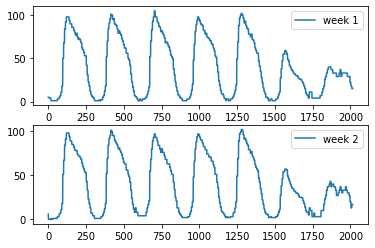

In [6]:
# the target curves from the call forecast
with open("target_crc.json") as f:
        target = json.load(f)

plt.subplot(2, 1, 1)
plt.plot(target["week1"], label="week 1")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(target["week2"], label="week 2")
plt.legend()


Week 1
----------

In [7]:
# create a planner for the first week

week1Planner = StaffPlanner()

In [8]:
# configure the planner

week1Planner.setStaffingTarget(target["week1"], days=7, slot_length=5)

for code, agent in agents.items():
    
    # W is the work shift that can be assigned on woork days
    # X is the shift that can be assigned on the weekend
    W, X = work_shifts_for_agent(agent)
    
    # W is always assigned on sun-thu
    # X is always assigned on weekends
    A  = W*W*W*W*W*X*R # R is assigned on sun
    B  = W*W*W*W*W*R*X # R is assigned on sat
    
    # on the very first week we assign the rest shift either on saturday or on sunday
    rule = A + B # either A or B
    
    # finally we add the rule to the planner
    week1Planner.addAgentRule(code, rule)

In [9]:
# at this point the planner is ready to be launched
# (it takes a few minutes)

week1Planner.run(annealing_schedule=0.95, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 8.000000
performing final temperature calibration ...
final temperature: 0.000977
starting 176 simulated annealing steps from temperature 8.0000 (delta=0.9500) ...
  0% T=8.0000 E=244.2501 (3881 4064) ...
  1% T=7.6000 E=242.1895 (3881 4103) ...
  1% T=7.2200 E=237.4851 (3881 4101) ...
  2% T=6.8590 E=269.6600 (3881 4079) ...
  2% T=6.5160 E=245.3102 (3881 4108) ...
  3% T=6.1902 E=232.9145 (3881 4092) ...
  3% T=5.8807 E=253.0679 (3881 4130) ...
  4% T=5.5867 E=229.2125 (3881 4148) ...
  5% T=5.3074 E=236.2599 (3881 4165) ...
  5% T=5.0420 E=260.5530 (3881 4183) ...
  6% T=4.7899 E=271.5408 (3881 4184) ...
  6% T=4.5504 E=253.2272 (3881 4172) ...
  7% T=4.3229 E=259.4577 (3881 4193) ...
  7% T=4.1067 E=244.9888 (3881 4239) ...
  8% T=3.9014 E=247.3610 (3881 4249) ...
  9% T=3.7063 E=219.8710 (3881 4287) ...
  9% T=3.5210 E=238.5354 (3881 4257) ...
 10% T=3.3450 E=211.5125 (3881 4340) ...
 10% T=3.1777 E=212.8598 (3881

In [10]:
# retrieve the optimized plan

print(tabulate([[code, *week1Planner.getAgentPlan(code)] for code in agents]))

--------  -----  -----  -----  -----  -----  -----  -----
O4158251  S0800  S0800  S0800  S0800  S0800  R      S0730
O4158272  S1445  S1415  S1415  S1515  S1415  S1645  R
O4158541  S0845  S0900  S0815  S0815  S0845  R      S0845
O4158553  S0700  S0645  S0700  S0700  S0700  R      S0800
O4158577  S0730  S0730  S0730  S0730  S0730  S0815  R
O4158987  S1715  S1715  S1815  S1815  S1815  R      S1800
O4161034  S1715  S1800  S1745  S1815  S1745  S1545  R
O4161216  S0045  S0030  S0030  S0030  S0045  R      S0015
O4161281  S0630  S0615  S0615  S0630  S0630  R      S0645
O4161322  S1545  S1600  S1545  S1630  S1545  S1715  R
O4161357  S0700  S0700  S0700  S0700  S0700  S0730  R
O4161384  S0800  S0800  S0800  S0800  S0800  R      S0815
O4161466  S1800  S1815  S1800  S1745  S1715  R      S1645
O4161598  S0900  S0830  S0815  S0815  S0815  R      S0830
O4161815  S0915  S0930  S0915  S0915  S0915  S0830  R
O4161818  S0730  S0730  S0730  S0730  S0730  S0830  R
O4161831  S1000  S1000  S1000  S1000  S100

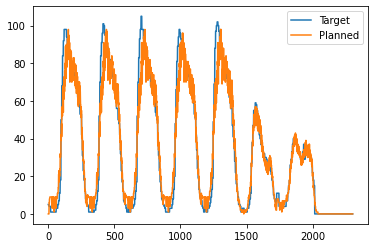

In [11]:
# and compare the planned staffing curve with the target

plt.plot(week1Planner.getTargetStaffing(), label="Target")
plt.plot(week1Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()

In [12]:
# the optimization report 

print(week1Planner.getReport())


          turning length: 7
                 week n°: 0
             slot length: 5 minutes
               agents n°: 194
         target staffing: 6594.00 hrs
      simulated staffing: 6590.92 hrs

   comfort energy weight: 0.00000

         annealing steps: 176
       temperature range: 8.00000 -> 0.00098
    temperature schedule: 0.95
       optimization time: 2.0 minutes

         staffing energy: 242.52662 -> 77.15975
          comfort energy: 12223.28571 -> 4327.71429
            TOTAL ENERGY: 242.52662 -> 77.15975

     day by day staffing:
                 day   1: 1095.83 hrs (target 1099.00 hrs error 0.29%)
                 day   2: 1098.67 hrs (target 1099.00 hrs error 0.03%)
                 day   3: 1099.25 hrs (target 1100.00 hrs error 0.07%)
                 day   4: 1099.67 hrs (target 1097.50 hrs error -0.20%)
                 day   5: 1099.17 hrs (target 1097.50 hrs error -0.15%)
                 day   6: 551.33 hrs (target 549.00 hrs error -0.43%)
                 d

In [13]:
# save plan for laterO

week1Plan = {code: week1Planner.getAgentPlan(code) for code in agents}

Week 2
----------

In [14]:
# create a new planner for the second week

week2Planner = StaffPlanner()

In [15]:
# configure the planner

week2Planner.setStaffingTarget(target["week2"], days=7, slot_length=5)

for code, agent in agents.items():
    
    # W is the work shift that can be assigned on work days
    # X is the shift that can be assigned on the weekend
    W, X = work_shifts_for_agent(agent)
    
    # get previous week plan for agent
    prev_week = week1Plan[code]
    
    # W is always assigned on sun-thu
    # X is always assigned on weekends
    A  = W*W*W*W*W*X*R # R is assigned on sun
    B  = W*W*W*W*W*R*X # R is assigned on sat
    C  = W*W*W*W*R*X*X # R is assigned on fri
    
    # implement rest alternation rule
    if prev_week[6] == "R":
        # the previous week the agent had rest on SUNDAY
        # we assign the rest on SATURDAY
        rule = B
    
    elif prev_week[5] == "R":
        # the previous week the agent had rest on SATURDAY
        # we assign the rest either on SUNDAY or on FRIDAY
        rule = A + C
        
    elif prev_week[4] == "R":
        # the previous week the agent had rest on FRIDAY
        # we assign the rest on SATURDAY
        rule = B
        
    else:
        # this is the very first week for the agent
        # assign the rest shift either on SATURDAY or on SUNDAY
        rule = A + B
    
    # finally we add the rule to the planner
    week2Planner.addAgentRule(code, rule)

In [16]:
# run planner

week2Planner.run(annealing_schedule=0.95, comfort_energy_weight=0.0)

performing initial temperature calibration ...
initial temperature: 4.000000
performing final temperature calibration ...
final temperature: 0.000977
starting 162 simulated annealing steps from temperature 4.0000 (delta=0.9500) ...
  0% T=4.0000 E=134.1876 (3881 4092) ...
  1% T=3.8000 E=141.4704 (3881 4104) ...
  1% T=3.6100 E=139.9170 (3881 4119) ...
  2% T=3.4295 E=132.9301 (3881 4118) ...
  3% T=3.2580 E=132.6595 (3881 4143) ...
  3% T=3.0951 E=135.2018 (3881 4153) ...
  4% T=2.9404 E=129.1246 (3881 4163) ...
  4% T=2.7933 E=128.8617 (3881 4201) ...
  5% T=2.6537 E=125.9541 (3881 4169) ...
  6% T=2.5210 E=133.3942 (3881 4220) ...
  6% T=2.3949 E=132.9243 (3881 4244) ...
  7% T=2.2752 E=125.5887 (3881 4223) ...
  8% T=2.1614 E=120.1290 (3881 4212) ...
  8% T=2.0534 E=128.1143 (3881 4293) ...
  9% T=1.9507 E=128.1221 (3881 4302) ...
  9% T=1.8532 E=134.2677 (3881 4277) ...
 10% T=1.7605 E=127.8671 (3881 4343) ...
 11% T=1.6725 E=122.5989 (3881 4378) ...
 11% T=1.5889 E=123.6297 (3881

In [17]:
# retrieve the optimized plan

print(tabulate([[code, *week2Planner.getAgentPlan(code)] for code in agents]))

2 (3881 21729) ...
 88% T=0.0026 E=73.9072 (3881 21727) ...
 89% T=0.0025 E=73.9072 (3881 21796) ...
 90% T=0.0024 E=73.9072 (3881 21561) ...
 90% T=0.0022 E=73.9072 (3881 22493) ...
 91% T=0.0021 E=73.9072 (3881 22138) ...
 91% T=0.0020 E=73.9072 (3881 22328) ...
 92% T=0.0019 E=73.9072 (3881 22495) ...
 93% T=0.0018 E=73.9072 (3881 22223) ...
 93% T=0.0017 E=73.9072 (3881 22418) ...
 94% T=0.0016 E=73.9072 (3881 21770) ...
 95% T=0.0016 E=73.9072 (3881 22327) ...
 95% T=0.0015 E=73.9072 (3881 22364) ...
 96% T=0.0014 E=73.9072 (3881 21565) ...
 96% T=0.0013 E=73.9072 (3881 22054) ...
 97% T=0.0013 E=73.9072 (3881 21630) ...
 98% T=0.0012 E=73.9072 (3881 21487) ...
 98% T=0.0011 E=73.9072 (3881 21902) ...
 99% T=0.0011 E=73.9072 (3881 22062) ...
100% T=0.0010 E=73.9072 (3881 22218) ...
--------  -----  -----  -----  -----  -----  -----  -----
O4158251  S0745  S0800  S0800  S0800  S0800  S0815  R
O4158272  S1445  S1445  S1445  S1415  S1445  R      S1515
O4158541  S0830  S0815  S0845  S

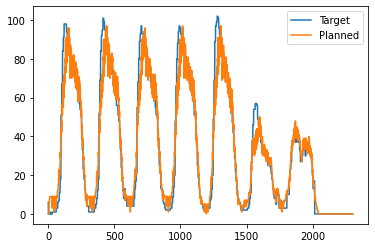

In [18]:
# and compare the planned staffing curve with the target

plt.plot(week2Planner.getTargetStaffing(), label="Target")
plt.plot(week2Planner.getPlannedStaffing(), label="Planned")
plt.legend()
plt.show()